Original paper: Bengio et al. 2003 A Neural Probabilistic Language Model
- challenges
    - curse of dimensionality for joint probability 
    - context: word sequence
    - similarity between words
- solution
    - a learned distributed feature vector (30-dimension) to represent each word in the vocabulary of 17000 words
    - each training sequence informs the model about a combinatorial number of other sentences
    - input layer is 30-dim vector per word, 3 words -> 90 neurons -> hidden layer -> softmax -> 17000 output neurons -> softmax P(w_i|context). most computation happens at the softmax output step.

In this notebook, we will **predict the next character based on 3 previous characters**.

# 1. string <> integer map for vocabulary

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# corpus
len(words)

32033

In [4]:
# build the vocabulary of chars and mappings to/from integers
# same as in bag-of-words
chars = sorted(list(set(''.join(words))))
# string to integer
stoi = {s:i+1 for i, s in enumerate(chars)}
# special char to represent start and end
stoi['.'] = 0
# integer to string
itos = {i:s for s, i in stoi.items()}
print (itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset and see how it works

block_size = 3
X, Y = [], []
for w in words[:5]:
    print ('--------------')
    print (w)
    # integer 0 -> .
    # ... ---> e
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print (''.join(itos[i] for i in context), '--->', itos[ix])
        print ('context before:', context)
        print ('output char:',ch)
        print ('output index',ix)

        # sliding window to the next context
        context = context[1:] + [ix]
        print ('context after:', context)
       
    
X=torch.tensor(X)
Y=torch.tensor(Y)

--------------
emma
... ---> e
context before: [0, 0, 0]
output char: e
output index 5
context after: [0, 0, 5]
..e ---> m
context before: [0, 0, 5]
output char: m
output index 13
context after: [0, 5, 13]
.em ---> m
context before: [0, 5, 13]
output char: m
output index 13
context after: [5, 13, 13]
emm ---> a
context before: [5, 13, 13]
output char: a
output index 1
context after: [13, 13, 1]
mma ---> .
context before: [13, 13, 1]
output char: .
output index 0
context after: [13, 1, 0]
--------------
olivia
... ---> o
context before: [0, 0, 0]
output char: o
output index 15
context after: [0, 0, 15]
..o ---> l
context before: [0, 0, 15]
output char: l
output index 12
context after: [0, 15, 12]
.ol ---> i
context before: [0, 15, 12]
output char: i
output index 9
context after: [15, 12, 9]
oli ---> v
context before: [15, 12, 9]
output char: v
output index 22
context after: [12, 9, 22]
liv ---> i
context before: [12, 9, 22]
output char: i
output index 9
context after: [9, 22, 9]
ivi ---

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X[:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [8]:
Y[:5]

tensor([ 5, 13, 13,  1,  0])

# 2. feature vector

In [9]:
Vdim = len(stoi.keys())
Vdim

27

In [10]:
# take 27 unique chars, put into a 2-D feature vector
# layer with 27 input and 2 output

Cdim = 2
# initialize with random numbers from a normal distribution with mean `0` and variance `1`
C = torch.randn((Vdim, Cdim))
C

tensor([[-0.4464, -0.6289],
        [ 1.3162, -0.2359],
        [ 1.3732,  0.4287],
        [-0.0174,  0.2338],
        [ 0.3223,  0.4244],
        [-0.3297, -0.0899],
        [-0.3791,  0.2541],
        [-0.8308,  0.4593],
        [ 1.5862,  0.9561],
        [-0.5079,  0.7066],
        [ 0.5257,  1.8360],
        [-0.7879,  1.7276],
        [ 0.5974,  1.3534],
        [-1.2337, -0.4362],
        [-1.8687, -1.5495],
        [ 1.0291, -0.0078],
        [ 1.7785,  0.6016],
        [ 1.2043, -0.8093],
        [-0.0207,  0.7163],
        [ 0.0288,  1.1582],
        [-1.0672, -1.6540],
        [-0.9492,  0.2938],
        [-0.1061, -1.3482],
        [ 0.3623, -0.1373],
        [-0.0161, -0.2087],
        [-0.8985, -0.2570],
        [-0.4422,  0.4705]])

## embedding of the integer (feature vector for a char)
1. index for C
2. one-hot encodding @ C

### 1. index for C

In [11]:
# prefered. it is FASTER than matrix multiplication
C[0]

tensor([-0.4464, -0.6289])

In [12]:
C[stoi['.']]

tensor([-0.4464, -0.6289])

In [13]:
C[5]

tensor([-0.3297, -0.0899])

### 2. one-hot encodding @ C

In [14]:
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [15]:
# one_hot is int, C is float, does not know how to multiply
F.one_hot(torch.tensor(5), num_classes=27) @ C

RuntimeError: expected scalar type Long but found Float

In [16]:
F.one_hot(torch.tensor(5), num_classes=27).dtype

torch.int64

In [17]:
# matrix multiplication to get the i-th row from C
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.3297, -0.0899])

## embedding of X

In [18]:
C[0]

tensor([-0.4464, -0.6289])

In [19]:
C[[0,1,2,2,2]]

tensor([[-0.4464, -0.6289],
        [ 1.3162, -0.2359],
        [ 1.3732,  0.4287],
        [ 1.3732,  0.4287],
        [ 1.3732,  0.4287]])

In [20]:
# retrieve value from a matrix
C[torch.tensor([0,1,2,2,2])]

tensor([[-0.4464, -0.6289],
        [ 1.3162, -0.2359],
        [ 1.3732,  0.4287],
        [ 1.3732,  0.4287],
        [ 1.3732,  0.4287]])

In [21]:
# from 2 words, 32 training samples
X.shape

torch.Size([32, 3])

In [22]:
X
# X is training data, each X[i] is 3 word in a row
# X[a,b] is the b-th char in the a-th record

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [23]:
X[10,2]

tensor(9)

In [24]:
itos[X[10,2].item()]

'i'

In [25]:
# index 1 of C is a 2-dim value
# each char is encoded in a 2-d array in C
# get the embedding fromm C for a char 
C[X[10,2]]

tensor([-0.5079,  0.7066])

In [26]:
# [32, 3]
# [27, 2]
# [32, 3, 2]
C[X].shape

torch.Size([32, 3, 2])

In [27]:
# X is all the chars in all trainign record
# each char -> 2D 
C[X]

tensor([[[-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289]],

        [[-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.3297, -0.0899]],

        [[-0.4464, -0.6289],
         [-0.3297, -0.0899],
         [-1.2337, -0.4362]],

        [[-0.3297, -0.0899],
         [-1.2337, -0.4362],
         [-1.2337, -0.4362]],

        [[-1.2337, -0.4362],
         [-1.2337, -0.4362],
         [ 1.3162, -0.2359]],

        [[-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289]],

        [[-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [ 1.0291, -0.0078]],

        [[-0.4464, -0.6289],
         [ 1.0291, -0.0078],
         [ 0.5974,  1.3534]],

        [[ 1.0291, -0.0078],
         [ 0.5974,  1.3534],
         [-0.5079,  0.7066]],

        [[ 0.5974,  1.3534],
         [-0.5079,  0.7066],
         [-0.1061, -1.3482]],

        [[-0.5079,  0.7066],
         [-0.1061, -1.3482],
         [-0.5079,  0.7066]],

        [[-0.1061, -1

# 3. build neural network with the embedded input

In [28]:
# embedding
# C[X] contains the embedding for all input for [3,2]
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [29]:
# use the word2vec architeture from the paper
# hidden layer

# number of inputs is 3X2: 2 dimension embedding with 3 words
# number of neurons (output): 100
block_size = 3
Cdim = 2
n_input1 = block_size * Cdim
n_output1 = 100

W1 = torch.randn([n_input1,n_output1])
# bias
b1 = torch.rand(n_output1)

# we usually do emb @ W1 + b1
# but embedding is staked, need to flatten it

In [30]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

## concat input of 3 words into a single vector
1. cat: not efficent, use memory to create new tensor
2. view: efficient!

### 1. cat

In [31]:
# 1st word 
emb[:, 0, :].shape

torch.Size([32, 2])

In [32]:
# concat the input to the correct dimension
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=0).shape

torch.Size([96, 2])

In [33]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [34]:
# there are 32 training samples, we want for each training sample, all 3 words are combined
# -> [32, 2*3]
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[-0.4464, -0.6289, -0.4464, -0.6289, -0.4464, -0.6289],
        [-0.4464, -0.6289, -0.4464, -0.6289, -0.3297, -0.0899],
        [-0.4464, -0.6289, -0.3297, -0.0899, -1.2337, -0.4362],
        [-0.3297, -0.0899, -1.2337, -0.4362, -1.2337, -0.4362],
        [-1.2337, -0.4362, -1.2337, -0.4362,  1.3162, -0.2359],
        [-0.4464, -0.6289, -0.4464, -0.6289, -0.4464, -0.6289],
        [-0.4464, -0.6289, -0.4464, -0.6289,  1.0291, -0.0078],
        [-0.4464, -0.6289,  1.0291, -0.0078,  0.5974,  1.3534],
        [ 1.0291, -0.0078,  0.5974,  1.3534, -0.5079,  0.7066],
        [ 0.5974,  1.3534, -0.5079,  0.7066, -0.1061, -1.3482],
        [-0.5079,  0.7066, -0.1061, -1.3482, -0.5079,  0.7066],
        [-0.1061, -1.3482, -0.5079,  0.7066,  1.3162, -0.2359],
        [-0.4464, -0.6289, -0.4464, -0.6289, -0.4464, -0.6289],
        [-0.4464, -0.6289, -0.4464, -0.6289,  1.3162, -0.2359],
        [-0.4464, -0.6289,  1.3162, -0.2359, -0.1061, -1.3482],
        [ 1.3162, -0.2359, -0.1061, -1.3

In [35]:
emb.shape

torch.Size([32, 3, 2])

In [36]:
# Removes a tensor dimension.
# Returns a tuple of all slices along a given dimension, already without it.

torch.unbind(emb, dim=1)

(tensor([[-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.3297, -0.0899],
         [-1.2337, -0.4362],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [ 1.0291, -0.0078],
         [ 0.5974,  1.3534],
         [-0.5079,  0.7066],
         [-0.1061, -1.3482],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [ 1.3162, -0.2359],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.5079,  0.7066],
         [ 0.0288,  1.1582],
         [ 1.3162, -0.2359],
         [ 1.3732,  0.4287],
         [-0.3297, -0.0899],
         [ 0.5974,  1.3534],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [ 0.0288,  1.1582],
         [ 1.0291, -0.0078],
         [ 1.7785,  0.6016],
         [ 1.5862,  0.9561]]),
 tensor([[-0.4464, -0.6289],
         [-0.4464, -0.6289],
         [-0

In [37]:
# unbind and then concat
torch.cat(torch.unbind(emb, dim=1),dim=1).shape

torch.Size([32, 6])

### 2. view
very efficient because a view does not create a new tensor; instead, it just returns a tensor which is a different view on the underlying data (physical storage)
http://blog.ezyang.com/2019/05/pytorch-internals/

In [38]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [39]:
a.shape

torch.Size([18])

In [40]:
a.view([2,9])

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [41]:
a.view([9,2])

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [42]:
a.view([3,6])

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])

In [43]:
a.storage()
# numbers stored in 1D vector
# .view changes the 1D sequence into a tensor
# no copy of the value created

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.LongStorage of size 18]

In [44]:
emb.shape

torch.Size([32, 3, 2])

In [45]:
# horray, 2 get stacked up to 3
emb.view([32,6])

tensor([[-0.4464, -0.6289, -0.4464, -0.6289, -0.4464, -0.6289],
        [-0.4464, -0.6289, -0.4464, -0.6289, -0.3297, -0.0899],
        [-0.4464, -0.6289, -0.3297, -0.0899, -1.2337, -0.4362],
        [-0.3297, -0.0899, -1.2337, -0.4362, -1.2337, -0.4362],
        [-1.2337, -0.4362, -1.2337, -0.4362,  1.3162, -0.2359],
        [-0.4464, -0.6289, -0.4464, -0.6289, -0.4464, -0.6289],
        [-0.4464, -0.6289, -0.4464, -0.6289,  1.0291, -0.0078],
        [-0.4464, -0.6289,  1.0291, -0.0078,  0.5974,  1.3534],
        [ 1.0291, -0.0078,  0.5974,  1.3534, -0.5079,  0.7066],
        [ 0.5974,  1.3534, -0.5079,  0.7066, -0.1061, -1.3482],
        [-0.5079,  0.7066, -0.1061, -1.3482, -0.5079,  0.7066],
        [-0.1061, -1.3482, -0.5079,  0.7066,  1.3162, -0.2359],
        [-0.4464, -0.6289, -0.4464, -0.6289, -0.4464, -0.6289],
        [-0.4464, -0.6289, -0.4464, -0.6289,  1.3162, -0.2359],
        [-0.4464, -0.6289,  1.3162, -0.2359, -0.1061, -1.3482],
        [ 1.3162, -0.2359, -0.1061, -1.3

In [46]:
emb.view([32,6]) == torch.cat(torch.unbind(emb,1),1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [47]:
(emb.view([X.shape[0],n_input1])@W1 + b1).shape

torch.Size([32, 100])

In [48]:
# use -1, it will infer the dim
h = emb.view([-1,n_input1])@W1 + b1
# b1 is 1D
# the broadcasting with + b1, align on the right
# 32, 100
#  1, 100
# => 
# 32, 100
# 32, 100 -> broadcasted 
# hidden layer
h

tensor([[-0.2642, -0.5217, -0.5207,  ...,  1.6704,  0.4607, -0.2842],
        [-0.5069, -0.4191,  0.5045,  ...,  1.2557,  0.1441,  0.3194],
        [-0.4562, -0.8144,  0.4525,  ...,  0.3793, -1.2262, -0.2351],
        ...,
        [ 0.8261,  3.0585,  2.8153,  ...,  0.3313,  4.5300,  2.5886],
        [ 0.4643,  1.9310,  3.9621,  ..., -1.6207,  2.8345,  0.2874],
        [ 3.2720, -2.1254, -0.0563,  ..., -1.9226,  2.0426, -0.6754]])

In [49]:
# final layer
# output is 27 possibe chars
n_output2 = Vdim
W2 = torch.randn([n_output1, n_output2])
b2 = torch.randn(n_output2)
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [50]:
counts = logits.exp()

In [51]:
# sum by row
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [52]:
prob

tensor([[1.8994e-06, 7.0665e-01, 2.4528e-14, 3.9459e-27, 3.7168e-15, 2.4027e-01,
         3.2191e-07, 8.0452e-07, 1.0725e-11, 1.2262e-09, 6.1807e-07, 4.1937e-11,
         6.2864e-16, 4.8229e-16, 1.9374e-11, 2.9170e-14, 8.0970e-09, 2.6827e-07,
         4.7176e-02, 5.6506e-06, 2.1539e-09, 1.4395e-21, 5.4801e-06, 3.7784e-07,
         6.4447e-20, 5.1319e-10, 5.8910e-03],
        [1.5634e-06, 5.8689e-03, 5.5907e-12, 3.6511e-24, 1.9378e-13, 1.6033e-02,
         1.3811e-09, 8.4612e-10, 9.2904e-12, 7.1332e-04, 7.8706e-05, 1.0586e-08,
         9.6776e-10, 2.4594e-09, 5.3621e-12, 1.4119e-13, 2.0930e-08, 8.0390e-03,
         1.7799e-03, 7.4927e-03, 9.5619e-08, 3.6570e-17, 5.1102e-07, 6.5709e-08,
         8.0131e-14, 9.7636e-08, 9.5999e-01],
        [2.5425e-13, 8.1657e-01, 4.2780e-17, 4.2832e-29, 1.9830e-15, 1.8342e-01,
         4.6704e-11, 6.8022e-12, 9.1839e-19, 7.4077e-16, 5.5468e-18, 9.6685e-19,
         8.7594e-16, 9.6322e-16, 3.2213e-11, 2.2215e-15, 8.7443e-19, 2.2657e-11,
         1.9050e-

In [53]:
Y.shape

torch.Size([32])

In [54]:
# we have 32 training records, and 27 dimensions
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [55]:
torch.arange(Y.shape[0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [56]:
# for each record, get the prob of the correct char
# some prob is really low -> log likelihood :D 
prob[torch.arange(Y.shape[0]), Y]

tensor([2.4027e-01, 2.4594e-09, 9.6322e-16, 8.2677e-01, 5.6912e-18, 2.9170e-14,
        1.0041e-07, 9.2010e-09, 1.5812e-28, 0.0000e+00, 7.0911e-14, 2.1457e-19,
        7.0665e-01, 5.9718e-21, 1.4916e-10, 4.2523e-22, 1.2262e-09, 7.8968e-03,
        4.5088e-21, 9.9985e-01, 1.1017e-36, 2.6719e-16, 3.3476e-06, 1.2857e-33,
        4.4522e-22, 5.6506e-06, 8.9681e-22, 1.4013e-44, 9.4136e-18, 3.0954e-21,
        7.0023e-38, 9.2334e-16])

In [57]:
# negative average log likelihood
# log of each prob, average, and then negative
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(inf)

# 4. train the neural net with backpropagation

In [58]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [59]:
Vdim=27
Cdim=2 # hyperparamter
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
n_output1 = 100 # hyperparamter
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2,n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

In [60]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [61]:
# forward pass
emb = C[X]
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
# softmax classification
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = - prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(17.7697)

## softmax loss from scratch v.s. F.cross_entropy
F.cross_entropy more efficient
- 1. numerically well-behaved, with more extreme valued weights, with exp() -> we could get very huge numbers. forward pass more efficient
- 2. backward pass is more efficient 
- 3. forward pass is more efficient. we do not create intermediate tensors as in logits.

In [62]:
F.cross_entropy(logits, Y)

tensor(17.7697)

In [63]:
# numerical out of range in float
logits = torch.tensor([-100,-3,0,100])
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0., 0., 0., nan])

In [64]:
# e^100 is too BIG, out of range in float
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [65]:
# use normalization to linearly offset the logits without affecting the prob
# pytorch internally SUBTRACTS the maximal value in the tensor
logits = torch.tensor([-100,-3,0,100]) - 100
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

## train with backward()

In [66]:
# train the neural net

learning_rate = 0.1

for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print (_, loss.item())
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data += -learning_rate * p.grad

0 17.76971435546875


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [67]:
# make sure to set requires_grad = true, otherwise will complain
for p in parameters:
    p.requires_grad=True
    
learning_rate = 0.5

for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print (_, loss.item())
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data += -learning_rate * p.grad

0 17.76971435546875
1 9.42310619354248
2 8.315447807312012
3 6.388716220855713
4 3.51501202583313
5 4.386330604553223
6 2.32904052734375
7 1.8342325687408447
8 2.4214775562286377
9 2.067505359649658


In [68]:
# we overfit the model with 32 data points and 3k parameters!
# torch reports the max value and the index
logits.max(1)

torch.return_types.max(
values=tensor([17.8802, 12.6695, 15.6311, 17.3821, 18.0480, 17.8802, 14.4196, 11.9789,
        14.2498, 13.5953, 12.4208, 15.7624, 17.8802, 17.1180, 14.2179, 15.5572,
        17.8802, 13.5108, 11.3627, 16.2610, 16.8473, 12.2349,  7.4047,  6.9497,
        13.6933, 17.8802, 16.9499, 13.7836,  9.7913, 14.5982, 18.5608, 12.1148],
       grad_fn=<MaxBackward0>),
indices=tensor([15, 12, 13,  1, 15, 15, 12, 12, 22,  9,  1,  0, 15, 15,  1, 15, 15, 15,
        15,  2,  5, 12, 12,  9,  0, 15, 15, 12,  8,  9,  1,  1]))

In [69]:
Y
# seems we predict super well
# we will not get 0 loss, because many words can be the starting char following "..."

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## train with all words

In [70]:
# build the dataset

# context to take, input X 
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
X=torch.tensor(X)
Y=torch.tensor(Y)

Vdim=27
Cdim=2 # hyperparamter
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
n_output1 = 100 # hyperparamter
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2,n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True

In [71]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [72]:
learning_rate = 0.5

for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print (_, loss.item())
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data += -learning_rate * p.grad

0 19.505226135253906
1 14.167920112609863
2 11.403884887695312
3 10.201157569885254
4 8.886395454406738
5 7.84780216217041
6 7.272636890411377
7 6.522163391113281
8 6.065618515014648
9 5.838536739349365


# 5. mini-batch
- using all data in forward and backward pass takes quite a long time in each iteration because each time we go through all the training examples!
- mini-batch randomly selects some data in each iteration for forward and backward pass
- pros: much faster in each iteration
- cons: less stable, may take longer time for loss to converge 

In [73]:
# generate index for the starting number 
# generate 32 of them
batch_size = 32
# Returns a tensor filled with random integers generated uniformly
torch.randint(0, X.shape[0], (batch_size,))

tensor([ 48049,  83229, 192839, 189260,  65187, 101329,   7717,  41259, 153683,
        122018,   5189, 147134,  29649, 101782, 192637, 109671, 132041,  63528,
        181138,  45778,  48738, 137578,  62475, 136876, 154447,   4831, 186918,
        131601, 148080,  94904, 126630, 193761])

In [74]:
torch.randint(0, X.shape[0], (batch_size,)).shape

torch.Size([32])

In [75]:
X[torch.randint(0, X.shape[0], (32,))].shape

torch.Size([32, 3])

In [76]:
# build the dataset

# context to take, input X 
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
X=torch.tensor(X)
Y=torch.tensor(Y)

Vdim=27
Cdim=2 # hyperparamter
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
n_output1 = 100 # hyperparamter
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2,n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True

In [77]:
# a good learning rate is around 1, 10 is too big, 0.01 is too slow in the beginning, but good towards later stage
learning_rate = 0.1

# much faster
# gradient is less reliable than the whole dataset
# direction is good enough 
# update with small amount of data for multiple steps > update with all the data with fewer steps
for _ in range(10000):
    # mini-batch index
    ix = torch.randint(0, X.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data += -learning_rate * p.grad

In [78]:
print (loss.item())

2.7195205688476562


# 6. find a reasonable learning rate

In [79]:
# hyperparameter tuning
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # search between 0.001 to 1
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [80]:
# build the dataset

# context to take, input X 
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
X=torch.tensor(X)
Y=torch.tensor(Y)

Vdim=27
Cdim=2 # hyperparamter
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
n_output1 = 100 # hyperparamter
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2,n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True

In [81]:
lri = []
lossi = []

for i in range(1000):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    
    # forward pass
    # only grab 32 rows
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = lrs[i]
    # update the parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    lri.append(lre[i])
    lossi.append(loss)
    
    print (loss.item())

20.058767318725586
18.386871337890625
20.938833236694336
18.30322265625
18.207124710083008
20.926156997680664
19.694604873657227
20.796886444091797
18.43265151977539
17.471906661987305
17.41988182067871
18.475698471069336
21.594234466552734
20.208314895629883
18.260589599609375
20.787334442138672
18.640947341918945
21.286579132080078
19.08941650390625
19.984092712402344
19.909046173095703
17.2227725982666
18.984329223632812
18.248714447021484
19.701366424560547
16.733842849731445
17.595561981201172
19.489112854003906
18.0367488861084
17.623903274536133
18.184213638305664
18.172489166259766
16.67631721496582
19.491979598999023
18.97934913635254
21.72498321533203
19.489974975585938
16.01494789123535
21.133420944213867
18.17195701599121
19.101388931274414
19.54134178161621
17.296428680419922
17.832054138183594
18.379337310791016
17.681211471557617
16.202953338623047
19.22760772705078
16.480175018310547
17.625823974609375
17.91048240661621
20.03180694580078
15.48385238647461
20.13036727905

3.143970251083374
2.5822694301605225
3.616262674331665
3.358060598373413
3.2837748527526855
3.4139809608459473
3.3856797218322754
2.7517240047454834
2.959219455718994
3.2085742950439453
3.230847120285034
3.00468111038208
2.6261143684387207
3.411679983139038
2.6447250843048096
2.7005319595336914
3.232732057571411
2.8750433921813965
3.520543098449707
2.8991739749908447
2.8904154300689697
3.335700273513794
3.2348315715789795
3.2892212867736816
3.896378993988037
2.8900647163391113
3.0431835651397705
3.039491891860962
3.037858009338379
3.210955858230591
4.34665584564209
2.8819639682769775
3.726290225982666
3.7548255920410156
3.493394613265991
3.512141227722168
3.016710042953491
2.9070377349853516
3.4122490882873535
3.086726188659668
3.199303388595581
3.335646390914917
3.1801059246063232
3.533473491668701
3.0448317527770996
2.899057149887085
3.0487630367279053
3.3654282093048096
3.331571578979492
2.6786227226257324
3.215420722961426
2.7102489471435547
3.626858949661255
3.428629159927368
2.43

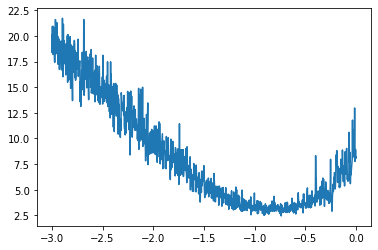

In [82]:
# in the beginning, as we increase the learning rate, we are not so stable 
# somewhere around 10**-1 = 0.1
plt.plot(lri, lossi)

In [83]:
# over the late stage, loss increases, diverged!
print (min(lossi).item())

2.43825101852417


# 7. cross-validation
train, valid, test split

80%, 10%, 10%

param, hyperparam, evaluate (few times)

In [84]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
# shuffle
random.shuffle(words)
train_perc = 0.8
dev_perc = 0.1
test_perc = 0.1

n1=int(train_perc*len(words))
n2=int((train_perc + dev_perc)*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [85]:
# training dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [86]:
Vdim=27
Cdim=2 # hyperparamter
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
n_output1 = 100 # hyperparamter
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2,n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True

In [87]:
# find a reasonable learning rate 
lri = []
lossi = []
learning_rate = 1

for i in range(100000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    # only grab 32 rows
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 #lrs[i]
    # update the parameters
    for p in parameters:
        p.data += -lr * p.grad
        
#     lri.append(lre[i])
    lossi.append(loss)
    

In [88]:
# compute loss on dev dataset
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print ('train loss', loss.item())

# can have even smaller loss with smaller learning rate
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print ('dev loss', loss.item())

train loss 2.321897268295288
dev loss 2.329921007156372


# 8. use a bigger hidden layer

In [89]:
Vdim=27
Cdim=2 # hyperparamter
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
batch_size = 32
n_output1 = 300 # hyperparamter
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2, n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True

In [90]:
# run this a bit more times to see if we can reduce loss further
stepi = []
lossi = []

for i in range(100000):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    
    # forward pass
    # only grab 32 rows
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # update the parameters
    # we could do learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    stepi.append(i)
    lossi.append(loss)

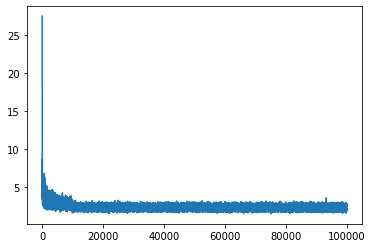

In [91]:
plt.plot(stepi, lossi)
# there is flucturation because of mini-batch
# increase batch size to be more stable

In [92]:
# compute loss on dev dataset
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print ('train loss', loss.item())

# can have even smaller loss with smaller learning rate
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print ('dev loss', loss.item())

train loss 2.329075336456299
dev loss 2.3230931758880615


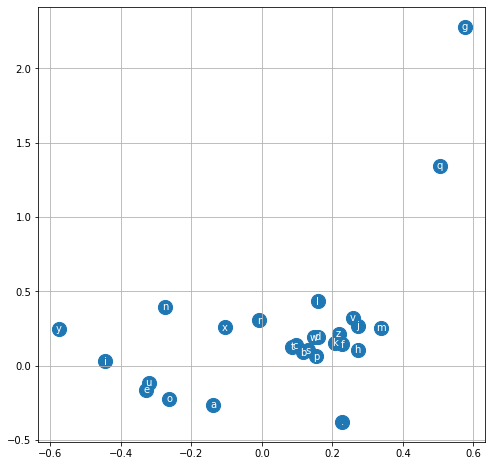

In [93]:
# visualize the embedding

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    # plt.text(x,y, the actual text)
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# visualize the char with the 2-D embeddin
# C learns to separate stuff
# aeiou are similar 

# 9. increase embedding size

In [94]:
Vdim=27
Cdim=10 # hyperparamter
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
batch_size = 32
n_output1 = 200 # hyperparamter
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2, n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True

In [95]:
# run this a bit more times
    
# find a reasonable learning rate 
lri = []
lossi = []
stepi = []

In [96]:
for i in range(100000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    # only grab 32 rows
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i < 10000 else 0.01
    # update the parameters
    for p in parameters:
        p.data += -lr * p.grad
        
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item()) # plot log-loss to squash it in

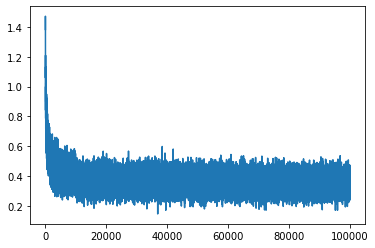

In [97]:
plt.plot(stepi, lossi)
# there is flucturation because of mini-batch
# increase batch size to be more stable

In [98]:
# compute loss on dev dataset
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print ('train loss', loss.item())

# can have even smaller loss with smaller learning rate
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print ('dev loss', loss.item())

train loss 2.2576844692230225
dev loss 2.2767961025238037


# 10. generate new words with the trained model

In [99]:
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    
    out = []
    context = [0] * block_size # we start from ...
    while True:
        # embed current context using C
        # 1 dim training set size 
        emb = C[torch.tensor([context])] # (1, block_size, d), d is the embedding vector C 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # from the prob, sample by probability to get the next index 
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift to the next char
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break # stop 
            
    print (''.join(itos[i] for i in out))

careah.
ambyn.
vih.
jors.
revty.
salaysy.
jazhnen.
amerync.
kaqii.
nelania.
chaiiv.
kaleig.
halm.
joce.
quinn.
shon.
raiviani.
wanthon.
jaryni.
jace.


# 11. hyperparameter tuning

In [122]:
Cdims = [2, 30, 50]
n_output1s = [100, 200, 300]

In [123]:
%%time
loss_list = []

for Cdim in Cdims:
    for n_output1 in n_output1s:
        Vdim=27
        block_size = 3 # hyperparamter
        n_input1 = Cdim * block_size
        batch_size = 32
        n_input2 = n_output1
        n_output2 = Vdim

        g = torch.Generator().manual_seed(2147483647)
        C = torch.randn((Vdim, Cdim), generator=g)
        W1 = torch.randn((n_input1,n_output1), generator=g)
        b1 = torch.randn(n_output1, generator=g)
        W2 = torch.randn((n_input2, n_output2), generator=g)
        b2 = torch.randn(n_output2, generator=g)
        parameters = [C, W1, b1, W2, b2]

        for p in parameters:
            p.requires_grad=True
            
        for i in range(100000):
            # mini-batch
            ix = torch.randint(0, Xtr.shape[0], (32,))

            # forward pass
            emb = C[Xtr[ix]] 
            h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, Ytr[ix])
            # backward pass

            # initalize all gradients
            for p in parameters:
                p.grad = None

            loss.backward()
            
            lr = 0.1 if i < 10000 else 0.01
            # update the parameters
            for p in parameters:
                p.data += -lr * p.grad
        
        # compute loss on dev dataset
        emb = C[Xtr]
        h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
        logits = h @ W2 + b2
        loss_train = F.cross_entropy(logits, Ytr)

        # can have even smaller loss with smaller learning rate
        emb = C[Xdev]
        h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
        logits = h @ W2 + b2
        loss_dev = F.cross_entropy(logits, Ydev)
        
        loss_list.append([Cdim, n_output1, loss_train.item(), loss_dev.item()])

CPU times: user 6min 14s, sys: 1min 35s, total: 7min 49s
Wall time: 7min 9s


In [124]:
import pandas as pd

In [125]:
df = pd.DataFrame(loss_list, columns = ['Cdim', 'hidden_layer_size','train loss', 'dev loss'])

In [126]:
dfs = df.sort_values('dev loss')
dfs

,Cdim,hidden_layer_size,train loss,dev loss
6,50,100,2.215908,2.255365
3,30,100,2.226047,2.261118
7,50,200,2.183852,2.274030
4,30,200,2.195534,2.276445
8,50,300,2.179892,2.299338
5,30,300,2.198899,2.305203
2,2,300,2.326979,2.324543
1,2,200,2.333926,2.331151
0,2,100,2.368216,2.365333


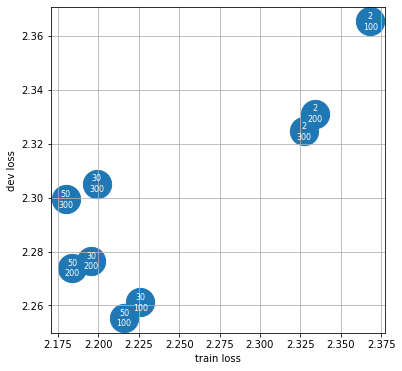

In [154]:
plt.figure(figsize=(6,6))
plt.scatter(dfs['train loss'], dfs['dev loss'],s=800)
plt.xlabel('train loss')
plt.ylabel('dev loss')
for i in range(len(dfs)):
    plt.text(dfs['train loss'][i],dfs['dev loss'][i], 
             str(df['Cdim'][i]) + '\n' + str(df['hidden_layer_size'][i]),
             ha='center', va='center', color='white',fontsize=8)
plt.grid('minor')
# note that the smalles train loss does not have the smallest dev loss 
# due to overfitting at Cdim=50, hidden_layer_size=300

## use the best hyperparameter to calculate loss on the test dataset

In [155]:
Cdim = dfs['Cdim'][0]
n_output1 = dfs['hidden_layer_size'][0]

In [156]:
%%time

Vdim=27
block_size = 3 # hyperparamter
n_input1 = Cdim * block_size
batch_size = 32
n_input2 = n_output1
n_output2 = Vdim

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((Vdim, Cdim), generator=g)
W1 = torch.randn((n_input1,n_output1), generator=g)
b1 = torch.randn(n_output1, generator=g)
W2 = torch.randn((n_input2, n_output2), generator=g)
b2 = torch.randn(n_output2, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad=True
    
for i in range(500000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    # only grab 32 rows
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass

    # initalize all gradients
    for p in parameters:
        p.grad = None

    loss.backward()

    if i < 10000:
        lr = 0.1 
    elif i < 100000:
        lr = 0.05
    elif i < 200000:
        lr = 0.01
    else:
        lr = 0.005
    # update the parameters
    for p in parameters:
        p.data += -lr * p.grad

CPU times: user 2min 40s, sys: 7.38 s, total: 2min 47s
Wall time: 2min 45s


In [157]:
# compute loss on dev dataset
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss_train = F.cross_entropy(logits, Ytr).item()

# can have even smaller loss with smaller learning rate
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss_dev = F.cross_entropy(logits, Ydev).item()

# report loss with test dataset
emb = C[Xte] # (32,3,2)
h = torch.tanh(emb.view(-1,n_input1) @ W1 + b1)
logits = h @ W2 + b2
loss_test = F.cross_entropy(logits, Yte).item()

In [158]:
print ('train loss: %.4f'%loss_train)
print ('dev loss: %.4f'%loss_dev)
print ('test loss: %.4f'%loss_test)

train loss: 2.2831
dev loss: 2.2875
test loss: 2.2865
